<a href="https://colab.research.google.com/github/shaibagon/GCMex/blob/master/Simple_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install -q torch

In [0]:
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import trange
sns.set()

Define A simple recurrent model

In [0]:
class MyRnn(nn.Module):
  def __init__(self, in_d=2, out_d=2, hidden_d=4, num_hidden=1):
    super(MyRnn, self).__init__()
    self.rnn = nn.RNN(input_size=in_d, hidden_size=hidden_d, num_layers=num_hidden)
    self.fc = nn.Linear(hidden_d, out_d)

  def forward(self, x, h0):
    r, h = self.rnn(x, h0)
    y = self.fc(r)  # no activation on the output
    return y, h

Define the input sequences, Shape of sequence is `time`x`batch`x`2d`

In [0]:
s1 = torch.tensor([[4, 15], [4, 14], [4, 13], [4, 12], [4, 11], [4, 10], [4, 9], [4, 8], [4,7], [4, 6], [4, 5], [4, 4], [4, 3], [4, 2]], dtype=torch.float)[:, None, :] 
s2 = torch.tensor([[4, 15], [5,15],[6,15],[7,15],[8,15],[9,15],[10,15],[11, 15],[12, 15],[12,14],[12,13],[12,12],[12,11],[12,10],[12,9],[12,8],[12,7],[12,6],[12,5]],dtype=torch.float)[:, None, :]


Normalize the sequences

In [0]:
x = torch.cat((s1,s2),dim=0)
mu = x.mean(dim=0)
sig=x.std(dim=0)
sequences = [(s1-mu)/sig, (s2-mu)/sig]  # pythonic list to hold sequences of un-even length

Train the model on both sequences

100%|██████████| 1000/1000 [00:04<00:00, 222.76it/s]


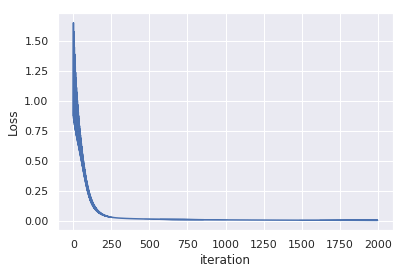

In [52]:
in_d = s1.shape[-1]
out_d = in_d
hidden_d = 8
num_hidden = 1
rnn = MyRnn(in_d, out_d, hidden_d, num_hidden)
loss = []
criterion = nn.MSELoss()
opt = torch.optim.SGD(rnn.parameters(), lr=0.01)
n_epochs = 1000
for e in trange(n_epochs):
  for s in sequences:
    pred, _ = rnn(s[:-1,...], torch.zeros(num_hidden, 1, hidden_d, dtype=torch.float))  # predict next step, init hidden state to zero at the begining of the sequence
    err = criterion(pred, s[1:, ...])  # predict next step for each step
    opt.zero_grad()
    err.backward()
    opt.step()
    loss.append(err.item())
plt.plot(loss)
plt.ylabel('Loss')
plt.xlabel('iteration')
plt.show()

Once the model is trained, we can predict

In [54]:
rnn.eval()
with torch.no_grad():
  k = 5 
  for si, s in enumerate(sequences):
    pred, h = rnn(s[:k,...], torch.zeros(num_hidden, 1, hidden_d, dtype=torch.float))  # given first k steps predict the next one
    print('seq {}, prev = {}  -> predicted {}th step = {}, actual step = {}'.format(si, s[k-1,...]*sig+mu, k, pred[-1, ...]*sig + mu, s[k, ...]*sig+mu))
    prev = (torch.round(pred[-1:, ...]*sig + mu) - mu) / sig  # round the prediction, attmepting to avoid accumulation of error
    # continue to predict 
    for j in  range(k+1, s.shape[0]):
      pred, h = rnn(prev, h)
      print('\t\tpredicted step {} (prev = {}) = {}, actual step = {}'.format(j, prev*sig+mu, pred[-1,...]*sig+mu, s[j, ...]*sig + mu))
      prev = (torch.round(pred*sig + mu) - mu) / sig
  print('\n')

seq 0, prev = tensor([[ 4., 11.]])  -> predicted 5th step = tensor([[ 4.0771, 10.1999]]), actual step = tensor([[ 4., 10.]])
		predicted step 6 (prev = tensor([[[ 4., 10.]]])) = tensor([[3.9769, 9.0732]]), actual step = tensor([[4., 9.]])
		predicted step 7 (prev = tensor([[[4., 9.]]])) = tensor([[3.8712, 7.8533]]), actual step = tensor([[4., 8.]])
		predicted step 8 (prev = tensor([[[4., 8.]]])) = tensor([[3.8472, 6.7704]]), actual step = tensor([[4., 7.]])
		predicted step 9 (prev = tensor([[[4., 7.]]])) = tensor([[3.8449, 5.6945]]), actual step = tensor([[4., 6.]])
		predicted step 10 (prev = tensor([[[4., 6.]]])) = tensor([[3.8923, 4.7349]]), actual step = tensor([[4., 5.]])
		predicted step 11 (prev = tensor([[[4., 5.]]])) = tensor([[3.9541, 3.8596]]), actual step = tensor([[4., 4.]])
		predicted step 12 (prev = tensor([[[4., 4.]]])) = tensor([[4.0380, 3.1076]]), actual step = tensor([[4., 3.]])
		predicted step 13 (prev = tensor([[[4., 3.]]])) = tensor([[4.1276, 2.4655]]), actual